In [1]:
import os
import re
import torch
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt

reg_types = ["fseb", "ps", "weight_decay", "weight_decay_ensemble", "weight_decay_pretrained"]
protein_order = ['parp1', 'fa7', '5ht1b', 'braf', 'jak2']

%config InlineBackend.figure_formats = ['svg']

/data/stat-cadd/bras5033/mood/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load entire dataset
data_set = pd.read_csv("data/zinc250k.csv")

Text(0, 0, 'ours')
Text(0, 0, 'ours (linear)')
Text(0, 0, 'ours (constant)')
Text(0, 0, 'ensemble')
Text(0, 0, 'pre-trained')
Text(0, 0, 'L2 regularisation')
Text(0, 0, 'weight decay')


[None, None]

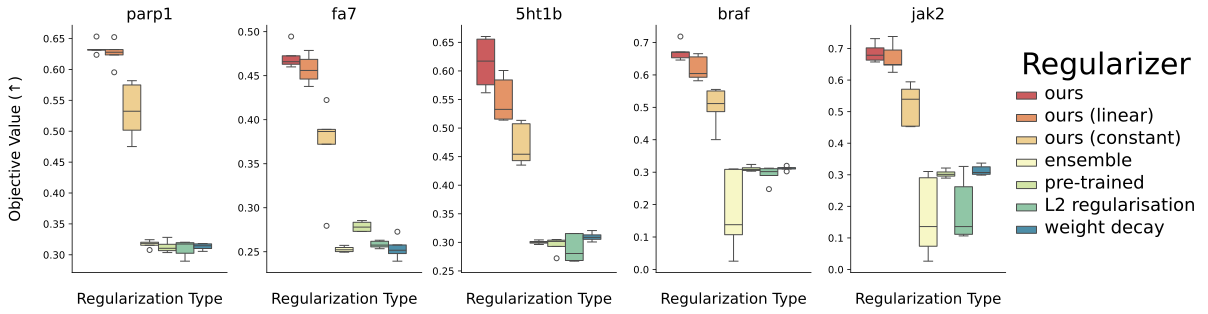

In [22]:
"""sample_dir = {
    "ours": "generated_samples_retrain_lowest_loss",
    "ours (linear)": "generated_samples_retrain_linear_drop_and_pretrain", 
    "ours (constant)": "generated_samples_retrain_no_drop_full", 
    "ensemble": "generated_samples_retrain_lowest_loss",
    "pre-trained": "generated_samples_retrain_linear_drop_and_pretrain",
    "L2 regularisation": "generated_samples_retrain_lowest_loss", 
    "weight decay": "generated_samples_retrain_lowest_loss",
}
"""

sample_dir = {
    "ours": "generated_samples_retrain_lowest_loss",
    "ours (linear)": "generated_samples_retrain_linear_drop_and_pretrain", 
    "ours (constant)": "generated_samples_retrain_no_drop_full", 
    "ensemble": "generated_samples_retrain_lowest_loss",
    "pre-trained": "generated_samples_retrain_linear_drop_and_pretrain",
    "L2 regularisation": "generated_samples_retrain_lowest_loss", 
    "weight decay": "generated_samples_retrain_lowest_loss",
}


best_models = []
results = []

for reg_key in sample_dir.keys():
    if reg_key == "ours" or reg_key == "ours (linear)" or reg_key == "ours (constant)":
        reg_type = "fseb"
    elif "L2 regularisation" in reg_key:
        reg_type = "ps"
    elif "weight decay" in reg_key and "ensemble" not in reg_key and "pretrained" not in reg_key:
        reg_type = "weight_decay"
    elif "ensemble" in reg_key:
        reg_type = "weight_decay_ensemble"
    elif "pre-trained" in reg_key:
        reg_type = "weight_decay_pretrained"      
    else:
        raise NotImplementedError
        
    protein_dirs = os.listdir(os.path.join(sample_dir[reg_key], reg_type))
    for protein_dir in protein_dirs:
        result_files = [f for f in os.listdir(os.path.join(sample_dir[reg_key], reg_type, protein_dir)) if f.endswith(".pkl")]
        for result_file in result_files:
            with open(os.path.join(sample_dir[reg_key], reg_type, protein_dir, result_file), "rb") as f:
                r = pickle.load(f)
                r["Regularizer"] = reg_key
                r["protein"] = protein_dir.split("_")[1]
                r["guidance_scale"] = float(result_file.split("_")[1])
                r["run_id"] = int(result_file[:-4].split("_")[-1])
                r["hit %"] = r["hit"] * 100
                r["top_ds_mean"] = r.loc[0, "top_ds"]
                r["top_ds_std"] = r.loc[1, "top_ds"]
                results.append(r.loc[0])
                
results = pd.DataFrame(results).reset_index(drop=True)
results = results[results["guidance_scale"] == 0.5]
results["top_ds_mean"] = results.apply(lambda x: x["top_ds_mean"] / data_set[x["protein"]].max(), axis=1)
prop, title = "top_ds_mean", "Objective Value (↑)"

g = sns.catplot(
    data=results,
    y=prop,
    col="protein",
    height=4,
    aspect=0.7,
    hue="Regularizer",
    sharey=False,
    sharex=True,
    kind="box",
    hue_order=sample_dir.keys(),
    col_order=protein_order,
    linewidth=1,
    palette="Spectral"
)

g.set_axis_labels("Regularization Type", title, fontsize=15, labelpad=20)

for ax in g.axes[0]:
    protein = ax.title.get_text().split(" = ")[-1]
    ax.set_xticks([])
    ax.set_title(ax.title.get_text().split(" = ")[-1], size=16)

sns.despine()

sns.move_legend(g, loc="center right", bbox_to_anchor=(1.06, 0.5))
for t in g._legend.get_texts():
    print(t)
    plt.setp(t, fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='30') # for legend title